# Phylogenetic analysis with Stan

## Simulation

- A random phylogenetic tree with 6 taxa was simulated using a coalescent process with a constant population size equal to 0.2 using the pure_kingman_tree function in Dendropy. (file: sim6.tree)

- An alignment (2000 sites) was simulated using a GTR model with relative rates (4, 40, 2, 2, 50, 1) and nucleotide frequencies (0.33, 0.25, 0.16, 0.26). No rate heterogeneity among sites. (file: sim6.fa)

- Every ranked labelled tree was enumerated (2700 phylogenies) using Python scripts. (file: sim6.trees)

## Analysis
Each tree was analysed using PyStan with the following model:
- Model: GTR
- Branches and topology: Coalescent prior
- Fequencies and relative rate: Flat Dirichlet priors

Variational distribution: meanfield

Number of samples: 1,000

# Processing

For each sample in each log file generated by Stan, I recalculated (log) posteriors, likelihoods, and priors using the *true* densities.

## BEAST2
A single BEAST run was used to sample from the posterior using the same model and priors. (GTR model, Dirichlet and coalescent priors).



In [63]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dendropy


def remove_burnin(d, p=0.1):
    n = d.shape[0]
    return d.tail(int(n*(1.0-p)))


def draw_tree(fig, tree, **kwargs):
    ax = fig.gca()
    
    fig_width = fig.get_dpi()
    #fig_width = fig.get_size_inches()*fig.dpi
    
    yspace = kwargs.get('yspace', 10)
    left_offset = kwargs.get('leftOffset', 5)
    branch_width = kwargs.get('branchWidth', 2)
    taxon_font_size = kwargs.get('taxonFontSize', 12)
    branch_tip_space = kwargs.get('branchTipSpace', 1.0)
    root_length = kwargs.get('rootLength', 0.0)
    
    showHeights = kwargs.get('showHeights', True)
    showTaxa = kwargs.get('showTaxa', True)
    showIntervals = kwargs.get('showIntervals', True)
    
    r = fig.canvas.get_renderer()
    scaler = float("inf")
    
    # keep track of coordinates for each node. Usefull for drawing the vertical branches
    coordinates = {}
    
    # contains a cleanup taxon name and its dimension in the plot
    taxa_labels = {}
    
    taxaCount = 0
    # distance to the root of each node
    distance_to_root = {}
    max_distance_to_root = 0
    for node in tree.preorder_node_iter():
        if node.parent_node is not None:
            depth = distance_to_root[node.parent_node] + node.edge.length
            distance_to_root[node] = depth
            
            if node.is_leaf():
                taxaCount += 1
                max_distance_to_root = max(depth, max_distance_to_root)
                
                if showTaxa:
                    name = str(node.taxon).rstrip("'").lstrip("'")
                    t = plt.text(-1, -1, name, alpha=0, size=taxon_font_size)
                    bb = t.get_window_extent(renderer=r)
                    taxa_labels[node] = (name, bb.width, bb.height)
                    taxon_height = bb.height
                    s = (fig_width - branch_tip_space  - bb.width)/depth
                    scaler = min(s, scaler)
                        
        else:
            distance_to_root[node] = 0.0

    if showTaxa == False:
        scaler = fig_width/max_distance_to_root
        
    y = taxon_height
    
    yy = taxon_height + taxaCount * (yspace + taxon_height)
    
    intervals = []
    
    for node in tree.postorder_node_iter():
        
        x1 = (distance_to_root[node] * scaler) + left_offset + root_length
        
        if node.edge.length is not None:
            x2 = x1 - (node.edge.length * scaler)
            
        if node.is_leaf():
            y1 = y2 = y - taxon_height * 0.5
            if showTaxa:
                ax.text(x1+branch_tip_space, y-(taxon_height-branch_width)*0.5, taxa_labels[node][0], va='top', size=taxon_font_size)
            y += yspace + taxon_height
        else:
            y1, y2 = [coordinates[c]['endY'] for c in node.child_node_iter()]
            # Vertical branch
            ax.plot([x1,x1], [y1,y2], lw=branch_width, color='steelblue', ls='-', zorder=9)
            
            y1 = y2 = y1 + (y2-y1)/2.0 # midpoint between childs
            
            if showHeights:
                ax.text(x1+1.0, y1, "%.3f" % (max_distance_to_root-distance_to_root[node]), size=taxon_font_size)
        
        # Horizontal branch
        if node.edge.length is not None and node.edge.length > 0.0:
            ax.plot([x1,x2], [y1,y2], lw=branch_width, color='steelblue', ls='-', zorder=9)
            coordinates[node] = {'startX': x2, 'endX': x1, 'startY': y2, 'endY': y2}
        elif node.edge.length is None and root_length > 0.0:
            ax.plot([x1,x1-root_length], [y1,y2], lw=branch_width, color='steelblue', ls='-', zorder=9)

    if showIntervals:
        nodes = sorted(coordinates.keys(), key=lambda n: max_distance_to_root-distance_to_root[n], reverse=True)
        
        x2 = left_offset + root_length
        ax.plot([x2, x2], [0, yy],'--', c='black')

        for i, node in enumerate(nodes):
            x1 = coordinates[node]['endX']
            ax.plot([x1, x1], [0, yy],'--', c='black')
            ax.text((x1 - x2)/2 + x2, 0, r'$\tau_{}$'.format(i+1), size=16)
            x2 = x1
            if max_distance_to_root-distance_to_root[node] < 1.0e-10:
                break
        
    ax.axis('off')

The true tree

In [64]:
tree = dendropy.Tree.get(path='/Users/mathieu/Projects/PhyloPyStan/sim6b/tree.tree', schema="newick", tree_offset=0)

The coalescent intervals

In [65]:
filter(lambda a: a != 0.0, tree.coalescence_intervals())
        

[0.0021475116604,
 0.00715455779713,
 0.0176229140132,
 0.03329931473257,
 0.07086579862443002]

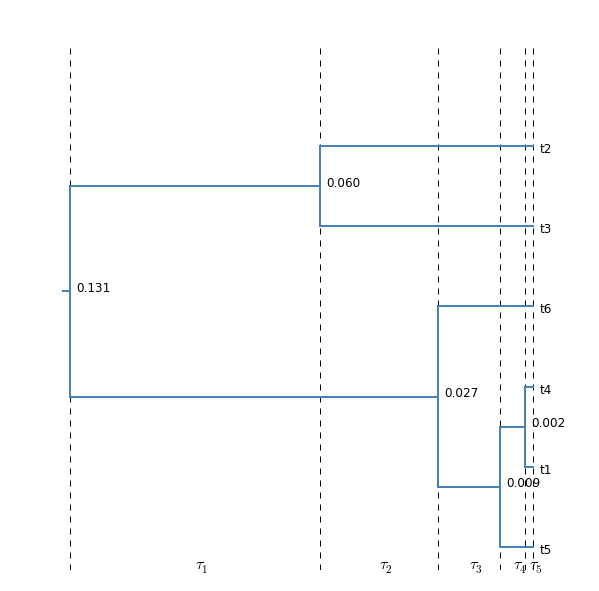

In [66]:
fig = plt.figure(figsize=(10,10), facecolor='w')
draw_tree(fig, tree, rootLength=1)

10,000 samples were drawn from the variational distribution for each tree resulting in 2,700,000 samples. These samples were aggregated in a single csv file.

In some cases Stan gave erroneous (e.g. frequency > 1) results so there is less samples in the file.

Relative rates are rescaled by setting GT to 1.0.

In the header of the csv file, 'tree' is the index of a ranked labelled history and 'ss' is the sample number for a given tree. In this case tree 872 is the true tree.

In [67]:
data = pd.read_csv('/Users/mathieu/Projects/PhyloPyStan/sim6b/sim6.fa.sorted.csv',sep='\t')

print(data.shape)

maxposterior = np.amax(data.posterior)
print('Maximum posterior: '+ str(maxposterior))

(2697688, 18)
Maximum posterior: -5124.693769


In [68]:
data.head()

,Sample,tree,ss,posterior,likelihood,prior,CoalescentConstant,rootHeight,freqParameter.1,freqParameter.2,freqParameter.3,freqParameter.4,rateAC,rateAG,rateAT,rateCG,rateCT,popSize
0,872185,872,337,-5124.795655,-5139.145106,14.349451,7.770200,0.135704,0.325960,0.250454,0.159009,0.264576,10.878975,117.408668,5.567134,7.646996,152.021312,0.072946
1,872805,872,957,-5124.920999,-5139.271869,14.350870,7.771619,0.134867,0.318016,0.261441,0.155427,0.265115,7.948801,96.724288,5.780052,5.213870,111.145258,0.097175
2,871848,872,0,-5124.693769,-5139.404199,14.710430,8.131178,0.123328,0.317398,0.259764,0.158182,0.264656,5.281736,61.059226,2.915054,2.672479,70.598147,0.087276
3,872638,872,790,-5125.638739,-5139.478155,13.839416,7.260165,0.128456,0.317578,0.265913,0.152425,0.264085,5.791982,63.992161,3.474199,2.747036,71.237994,0.138615
4,872765,872,917,-5124.923419,-5139.535581,14.612161,8.032910,0.124323,0.315884,0.262597,0.153857,0.267662,4.727339,61.491841,2.709931,3.279661,66.502878,0.064235


In [69]:
beast = pd.read_csv('/Users/mathieu/Projects/PhyloPyStan/sim6b/beast/topo/sim6.log', sep='\t', comment='#')
beast = remove_burnin(beast)
print(beast.shape)

(9000, 19)


In [70]:
beast.head()

,Sample,posterior,likelihood,prior,treeLikelihood,TreeHeight,freqParameter.1,freqParameter.2,freqParameter.3,freqParameter.4,rateAC,rateAG,rateAT,rateCG,rateCT,rateGT,popSize,CoalescentConstant,Unnamed: 18
1001,2002000,-5126.642104,-5142.008462,15.366358,-5142.008462,0.135333,0.312815,0.248988,0.160785,0.277412,0.080057,0.749539,0.049282,0.026812,0.873077,0.009299,0.154384,6.918791,NaN
1002,2004000,-5125.848232,-5143.070189,17.221957,-5143.070189,0.123773,0.315481,0.256772,0.153001,0.274746,0.080057,0.749539,0.025452,0.044534,0.981601,0.027923,0.059914,7.827866,NaN
1003,2006000,-5127.447224,-5142.188310,14.741086,-5142.188310,0.126493,0.315481,0.256772,0.153001,0.274746,0.080057,0.809481,0.025452,0.051040,0.981601,0.027923,0.028744,4.612517,NaN
1004,2008000,-5125.524521,-5143.056415,17.531894,-5143.056415,0.120251,0.315481,0.255074,0.154699,0.274746,0.052863,0.809481,0.045069,0.032622,0.981601,0.027923,0.063719,8.199378,NaN
1005,2010000,-5126.965095,-5143.136895,16.171800,-5143.136895,0.127030,0.321575,0.248980,0.155340,0.274105,0.051600,0.809481,0.045069,0.032622,0.981601,0.027923,0.112374,7.406624,NaN


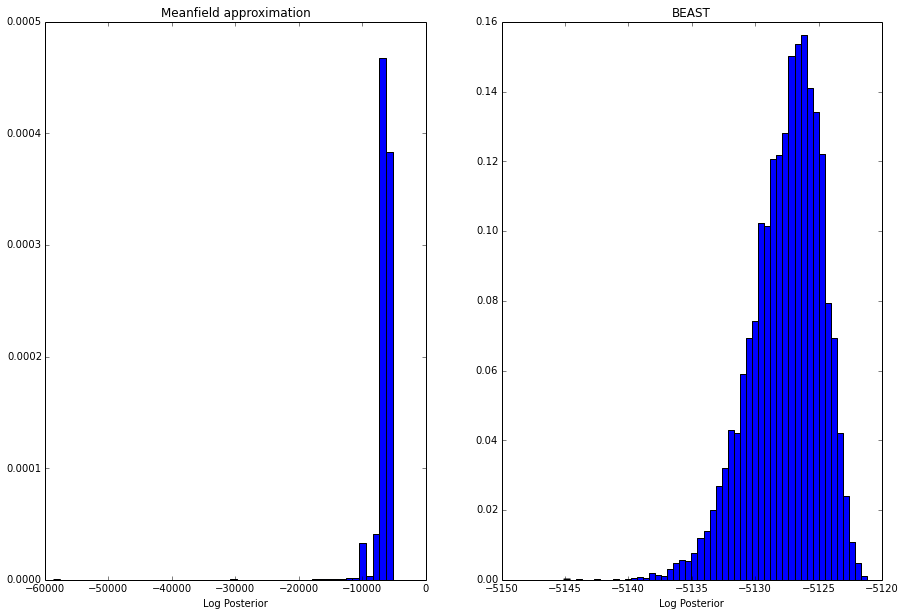

In [71]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(121)
_ = ax.hist(data.posterior, 50, normed=True)
plt.xlabel("Log Posterior")
plt.title("Meanfield approximation")

ax = fig.add_subplot(122)
_ = ax.hist(np.asarray(beast.posterior), 50, normed=True)
plt.xlabel("Log Posterior")
plt.title("BEAST")

[872]


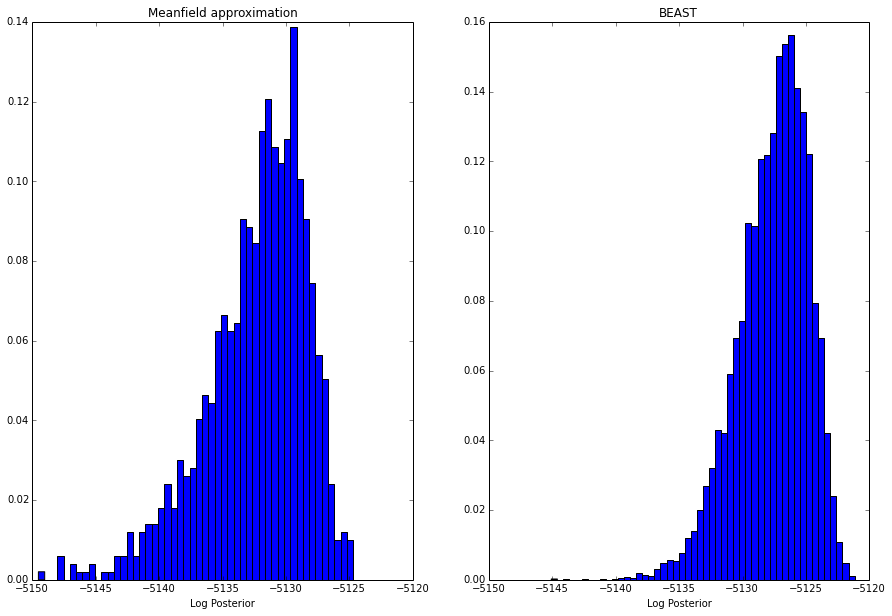

In [72]:
fig = plt.figure(figsize=(15,10))

cutoff = 25

ax = fig.add_subplot(121)
_ = ax.hist(data[data.posterior > maxposterior-cutoff].posterior, 50, normed=True)
plt.xlabel("Log Posterior")
plt.title("Meanfield approximation")
print(data[data.posterior > maxposterior-cutoff].tree.unique())

ax = fig.add_subplot(122)
_ = ax.hist(np.asarray(beast.posterior), 50, normed=True)
plt.xlabel("Log Posterior")
plt.title("BEAST")

Mean: 0.103832629371
Mean: 0.0948471481946


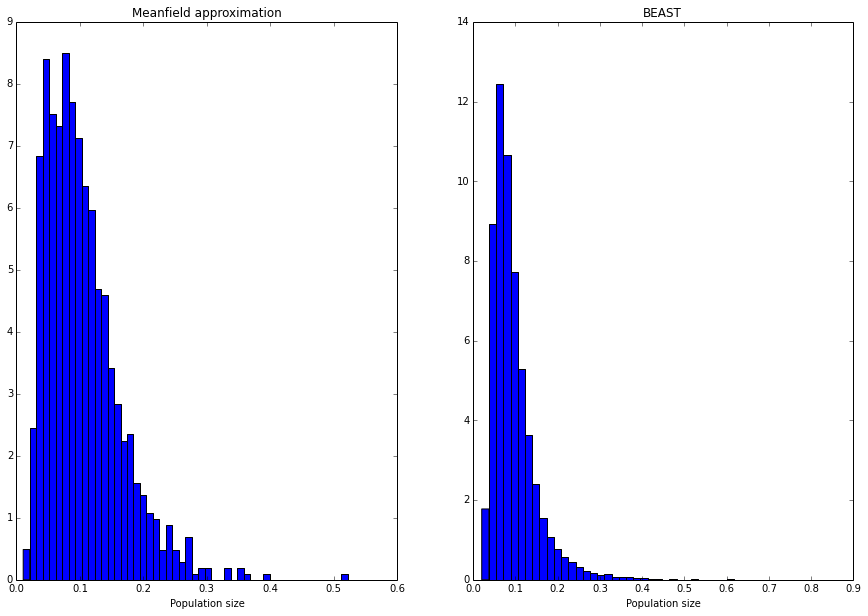

In [73]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(121)
_ = ax.hist(data[data.posterior > maxposterior-cutoff].popSize, 50, normed=True)
plt.xlabel("Population size")
plt.title("Meanfield approximation")

print('Mean: {}'.format(np.mean(data[data.posterior > maxposterior-cutoff].popSize)))

ax = fig.add_subplot(122)
_ = ax.hist(np.asarray(beast.popSize), 50, normed=True)
plt.xlabel("Population size")
plt.title("BEAST")
print('Mean: {}'.format(np.mean(beast.popSize)))

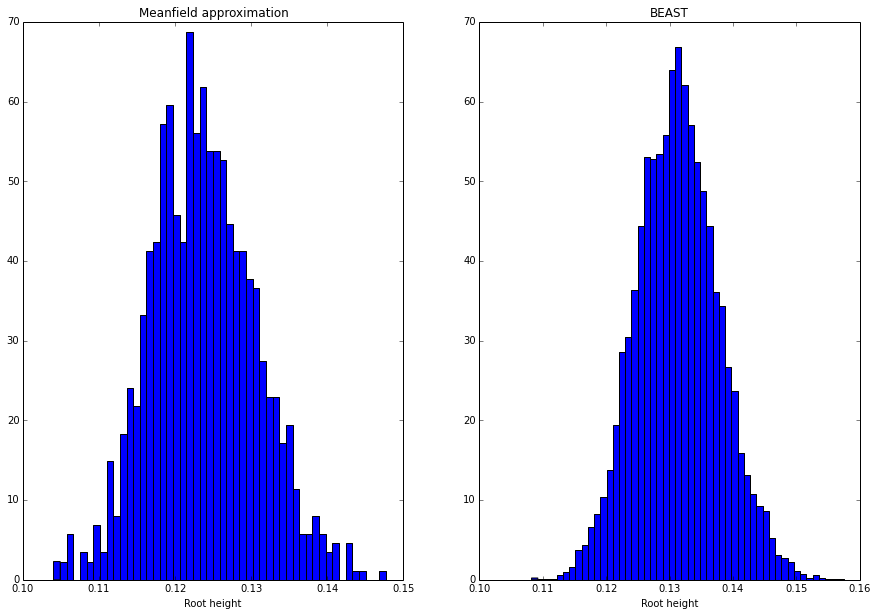

In [74]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(121)
_ = ax.hist(data[data.posterior > maxposterior-cutoff].rootHeight, 50, normed=True)
plt.xlabel("Root height")
plt.title("Meanfield approximation")

ax = fig.add_subplot(122)
_ = ax.hist(np.asarray(beast.TreeHeight), 50, normed=True)
plt.xlabel("Root height")
plt.title("BEAST")